In [59]:
!pip install torch_geometric

In [60]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from torch_geometric.utils import to_networkx
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [61]:
from torch_geometric.datasets import WebKB, Coauthor

# Доступные университеты в датасете
dataset = Coauthor(root='/tmp/Coauthor', name='Physics')
graph = dataset[0]

In [62]:
display(pd.DataFrame([[dataset, len(dataset), dataset.num_node_features, dataset.num_edge_features]],
                     columns=["Датасет",
                              "Количество графов",
                              "Количество признаков вершин",
                              "Количество признаков ребер",
                              ]).T)

,0
Датасет,"([(x, tensor([[0., 0., 0., ..., 0., 0., 0.],\..."
Количество графов,1
Количество признаков вершин,8415
Количество признаков ребер,0


In [63]:
from collections import deque

def get_train_test_val(graph, train_ratio=0.6, val_ratio=0.2):
    """Размечает вершины графа на train, validation и test"""
    # Инициализация графа и масок
    G = to_networkx(graph, to_undirected=True)
    train_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)

    # Вычисление целевого количества узлов для каждого набора
    target_train_count = int(train_ratio * graph.num_nodes)
    target_val_count = int(val_ratio * graph.num_nodes)

    visited = set()

    # Обход графа компонента связности за компонентом
    for start_node in range(graph.num_nodes):
        if start_node not in visited:
            queue = deque([start_node])

            while queue:
                current_node = queue.popleft()

                if current_node not in visited:
                    visited.add(current_node)

                    # Распределение узла по соответствующему набору
                    if train_mask.sum() < target_train_count:
                        train_mask[current_node] = True
                    elif val_mask.sum() < target_val_count:
                        val_mask[current_node] = True
                    else:
                        test_mask[current_node] = True

                    # Добавление непосещенных соседей в очередь
                    unvisited_neighbors = [
                        neighbor for neighbor in G.neighbors(current_node)
                        if neighbor not in visited
                    ]
                    queue.extend(unvisited_neighbors)

    # Присвоение масок графу
    graph.train_mask = train_mask
    graph.val_mask = val_mask
    graph.test_mask = test_mask

    return graph

In [64]:
graph = get_train_test_val(graph)

In [65]:
from sklearn.decomposition import PCA

def visualize_embeddings(h, color, title="Node Embeddings Visualization",
                        method='pca', figsize=(16, 8)):
    """Визуализация эмбеддингов узлов с использованием PCA или t-SNE."""

    embeddings = h.detach().cpu().numpy()
    color_array = color.cpu().numpy() if hasattr(color, 'cpu') else color

    fig, ax = plt.subplots(figsize=figsize)

    # Выбор метода понижения размерности
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        z = reducer.fit_transform(embeddings)
        variance_ratio = reducer.explained_variance_ratio_
        title_suffix = f" (PCA: {variance_ratio[0]:.1%}+{variance_ratio[1]:.1%} variance)"
    else:  # t-SNE как альтернатива
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        z = reducer.fit_transform(embeddings)
        title_suffix = " (t-SNE)"

    # Создание scatter plot с улучшенным оформлением
    scatter = ax.scatter(
        z[:, 0], z[:, 1],
        c=color_array,
        s=50,
        cmap="plasma",
        alpha=0.7,
        edgecolors='white',
        linewidth=0.3
    )

    # Настройка оформления
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{title}{title_suffix}", fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.2)

    # Добавление легенды для дискретных цветов
    if len(set(color_array)) <= 10:  # Добавляем легенду только для небольшого числа классов
        legend = ax.legend(*scatter.legend_elements(),
                          title="Classes",
                          loc="upper right",
                          bbox_to_anchor=(1.15, 1))
        ax.add_artist(legend)
    else:
        # Для многих классов используем colorbar
        plt.colorbar(scatter, ax=ax, label='Node labels', shrink=0.8)

    # Добавление информации о количестве точек
    ax.text(0.02, 0.98, f'Nodes: {len(z):,}',
            transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            verticalalignment='top')

    plt.tight_layout()
    plt.show()

In [66]:
from torch_geometric.data import Data
from torch_geometric.utils import subgraph
import torch

def create_subgraph(original_graph, node_indices):
    """
    Создает подграф из исходного графа, сохраняя все свойства узлов.

    Args:
        original_graph: Исходный граф torch_geometric.data.Data
        node_indices: Тензор индексов узлов для включения в подграф

    Returns:
        Data: Новый подграф с сохраненными свойствами узлов
    """
    # Создаем подграф ребер
    filtered_edge_index, _ = subgraph(
        node_indices,
        original_graph.edge_index,
        relabel_nodes=True
    )

    # Создаем новый объект графа с основными свойствами
    subgraph_data = Data(
        x=original_graph.x[node_indices],
        edge_index=filtered_edge_index,
        y=original_graph.y[node_indices]
    )

    # Копируем маски разбиения данных, если они существуют
    partition_masks = ['train_mask', 'val_mask', 'test_mask']

    for mask_name in partition_masks:
        if hasattr(original_graph, mask_name):
            original_mask = getattr(original_graph, mask_name)
            subgraph_mask = original_mask[node_indices]
            setattr(subgraph_data, mask_name, subgraph_mask)

    return subgraph_data



# Создаем подграф из первых 5000 узлов
node_indices = torch.arange(1000)
sub_g = create_subgraph(graph, node_indices)

# Детальная информация о созданном подграфе
print("=" * 50)
print("ПОДГРАФ УСПЕШНО СОЗДАН")
print("=" * 50)
print(f"Количество узлов: {sub_g.num_nodes:,}")
print(f"Количество ребер: {sub_g.num_edges:,}")
print(f"Размерность признаков: {sub_g.x.shape}")
print(f"Размерность меток: {sub_g.y.shape}")
print(f"Уникальные классы: {torch.unique(sub_g.y).tolist()}")

# Информация о масках
mask_info = []
for mask_name in ['train_mask', 'val_mask', 'test_mask']:
    if hasattr(sub_g, mask_name):
        mask = getattr(sub_g, mask_name)
        mask_info.append(f"{mask_name}: {mask.sum().item()} узлов")

if mask_info:
    print("Распределение по маскам:")
    for info in mask_info:
        print(f"  - {info}")

ПОДГРАФ УСПЕШНО СОЗДАН
Количество узлов: 1,000
Количество ребер: 486
Размерность признаков: torch.Size([1000, 8415])
Размерность меток: torch.Size([1000])
Уникальные классы: [0, 1, 2, 3, 4]
Распределение по маскам:
  - train_mask: 509 узлов
  - val_mask: 229 узлов
  - test_mask: 262 узлов


In [68]:
from torch_geometric.nn import GCNConv, BatchNorm, GraphNorm, GlobalAttention, GATConv, SAGEConv
import torch.nn.functional as F

class EnhancedGCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout=0.5):
        super().__init__()

        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, dataset.num_classes)

        self.bn1 = BatchNorm(hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)

        self.dropout = dropout

        # Skip connection веса
        self.skip_weights = torch.nn.Parameter(torch.ones(2))

    def forward(self, x, edge_index):
        # Первый блок
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # Второй блок с weighted residual
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        # Взвешенная residual connection
        x2 = self.skip_weights[0] * x2 + self.skip_weights[1] * x1
        x2 = F.relu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        # Третий блок
        x3 = self.conv3(x2, edge_index)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = F.dropout(x3, p=self.dropout, training=self.training)

        # Выходной слой
        x4 = self.conv4(x3, edge_index)
        return x4

model = EnhancedGCN(hidden_channels=16)
print(model)

EnhancedGCN(
  (conv1): GCNConv(8415, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 5)
  (bn1): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


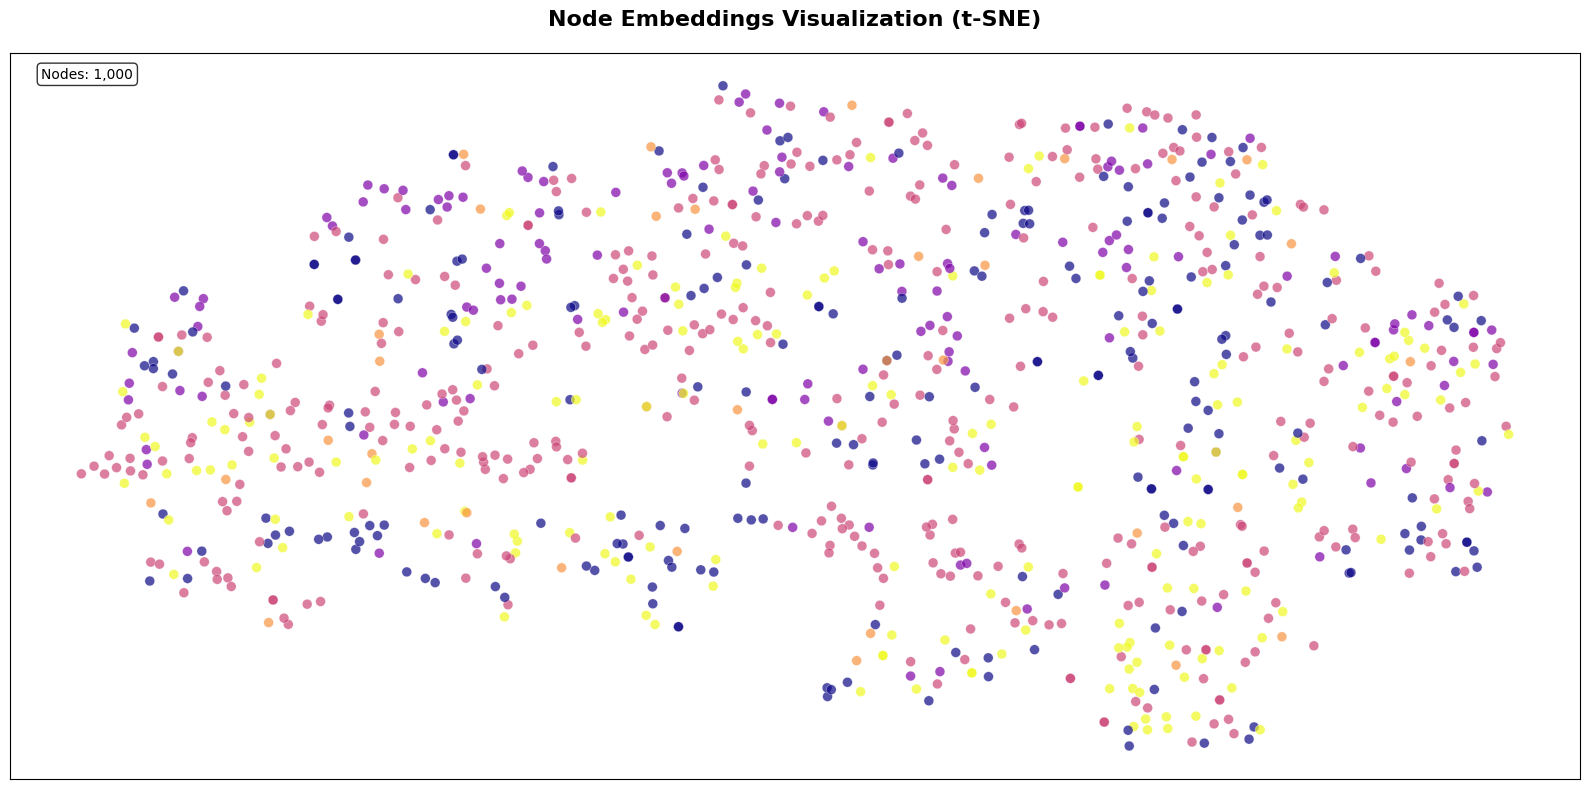

In [69]:
model.eval()
out = model(sub_g.x, sub_g.edge_index)
visualize_embeddings(out, color=sub_g.y, method='t-sne')

In [70]:
criterion = torch.nn.CrossEntropyLoss()

def train_model(model):
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(sub_g.x, sub_g.edge_index)  # Perform a single forward pass.
      loss = criterion(out[sub_g.train_mask], sub_g.y[sub_g.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def val_model(model):
      model.eval()
      out = model(sub_g.x, sub_g.edge_index)
      pred = out.argmax(dim=1)
      val_correct = pred[sub_g.val_mask] == sub_g.y[sub_g.val_mask]
      val_acc = int(val_correct.sum()) / int(sub_g.val_mask.sum())
      return val_acc

def test_model(model):
      model.eval()
      out = model(sub_g.x, sub_g.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[sub_g.test_mask] == sub_g.y[sub_g.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(sub_g.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

# Обучаем

In [71]:
# Более релевантные параметры для GCN (адаптированные под вашу архитектуру)
from tqdm import tqdm

learning_rates = [0.01, 0.001, 0.0001]
hidden_dims = [16, 32, 64, 128]
weight_decays = [0.0, 5e-4, 1e-3]

best_acc = 0
best_params = {}

# Общее количество комбинаций параметров
total_combinations = len(learning_rates) * len(hidden_dims) * len(weight_decays)

# Прогресс-бар для перебора гиперпараметров
with tqdm(total=total_combinations, desc="Hyperparameter search") as pbar:
    for lr in learning_rates:
        for hidden in hidden_dims:
            for wd in weight_decays:
                current_params = f"lr={lr}, hidden={hidden}, wd={wd}"
                pbar.set_postfix({
                    'Current': current_params,
                    'Best Acc': f'{best_acc:.4f}'
                })

                model = EnhancedGCN(hidden_channels=hidden)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

                # Прогресс-бар для эпох обучения (опционально)
                for epoch in tqdm(range(100), desc=f"Training", leave=False):
                    train_model(model)

                acc = val_model(model)

                if acc > best_acc:
                    best_acc = acc
                    best_params = {'lr': lr, 'hidden': hidden, 'wd': wd}

                pbar.update(1)

print(f"Best params: {best_params}, Accuracy: {best_acc:.4f}")


Hyperparameter search: 100%|██████████| 36/36 [03:19<00:00,  5.55s/it, Current=lr=0.0001, hidden=128, wd=0.001, Best Acc=0.7511]

Best params: {'lr': 0.0001, 'hidden': 32, 'wd': 0.0005}, Accuracy: 0.7511


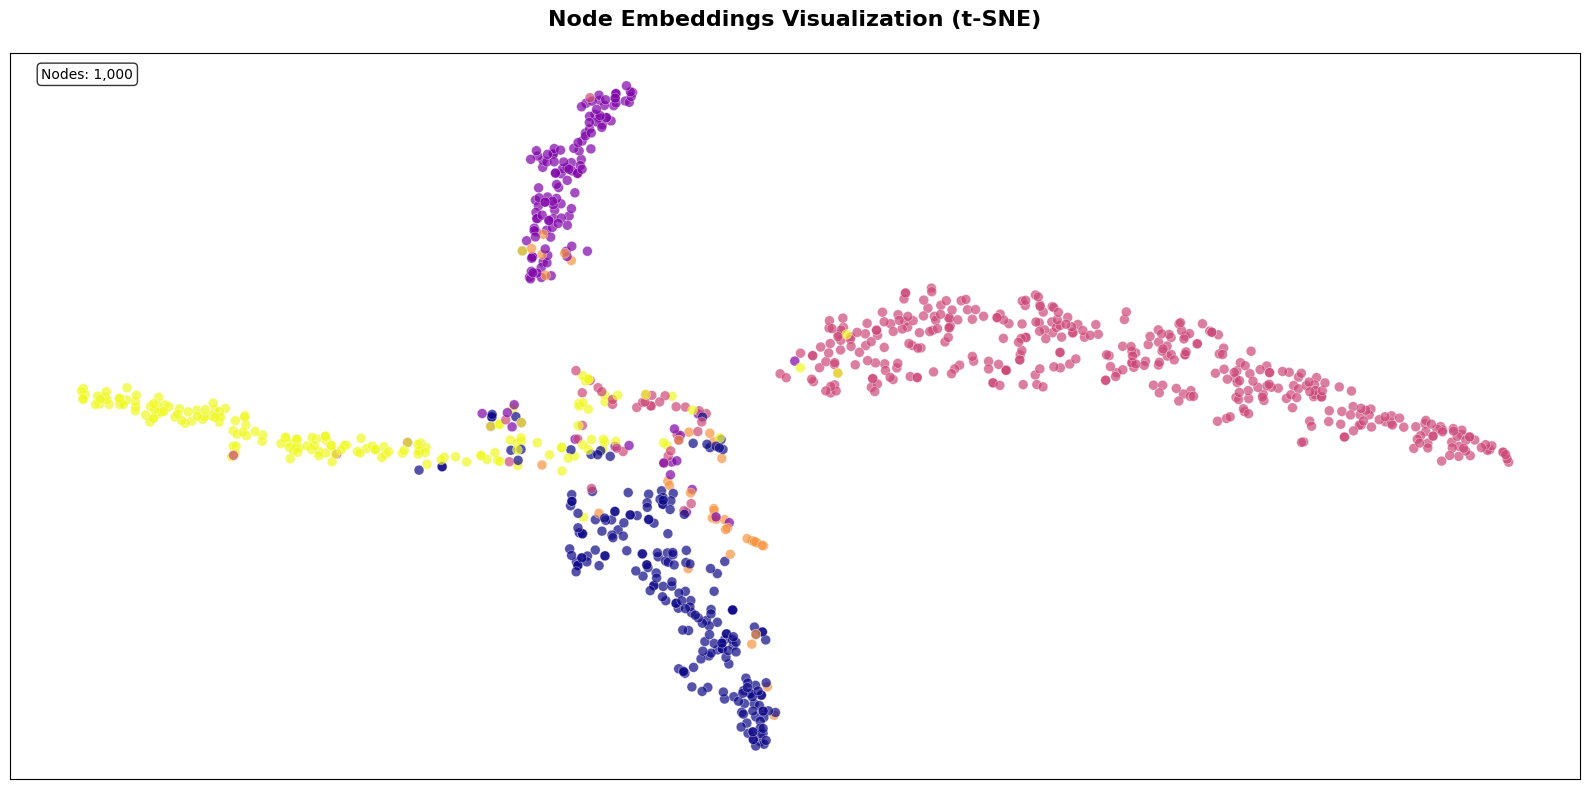

In [72]:
model.eval()
out = model(sub_g.x, sub_g.edge_index)
visualize_embeddings(out, color=sub_g.y, method='t-sne')

# Вижу, что если раньше классы стали хорошо отделимы. Точность: 0.75

# Сделаем кастомную реализацию

In [73]:
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.nn import BatchNorm

class CustomGCNLayer(nn.Module):
    """
    Кастомный слой GCN с residual connection.

    Реализует модифицированную версию GCN свертки:
    Z = A_tilde * (X * W^T) + X * B^T + bias
    где B - веса для residual connection
    """

    def __init__(self, input_channels, output_channels):
        super().__init__()

        # Матрица весов для трансформации признаков от соседей
        self.neighbor_weight = Parameter(torch.Tensor(output_channels, input_channels))

        # Матрица весов для residual connection (прямой связь от входных признаков)
        self.residual_weight = Parameter(torch.Tensor(output_channels, input_channels))

        # Вектор смещения
        self.bias = Parameter(torch.Tensor(output_channels))

        self._initialize_parameters()

    def _initialize_parameters(self):
        """Инициализация весов слоя."""
        # Инициализация Xavier для весов преобразования
        nn.init.xavier_uniform_(self.neighbor_weight)
        nn.init.xavier_uniform_(self.residual_weight)
        nn.init.zeros_(self.bias)

    def _build_normalized_adjacency(self, x, edge_index):
        """
        Строит нормализованную матрицу смежности с self-loops.

        Args:
            x: Матрица признаков узлов [num_nodes, num_features]
            edge_index: Матрица ребер [2, num_edges]

        Returns:
            Нормализованная матрица смежности A_tilde
        """
        num_nodes = x.size(0)

        # Создаем матрицу смежности
        adjacency_matrix = torch.zeros(num_nodes, num_nodes, device=x.device)
        source_nodes, target_nodes = edge_index
        adjacency_matrix[source_nodes, target_nodes] = 1.0

        # Добавляем self-loops (учет собственных признаков)
        adjacency_matrix += torch.eye(num_nodes, device=x.device)

        # Вычисляем степени узлов
        node_degrees = torch.sum(adjacency_matrix, dim=1)

        # Нормализуем: D^{-1/2} * A * D^{-1/2}
        degree_inv_sqrt = torch.pow(node_degrees, -0.5)
        degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0  # Обработка нулевых степеней

        degree_matrix_inv_sqrt = torch.diag(degree_inv_sqrt)
        normalized_adjacency = degree_matrix_inv_sqrt @ adjacency_matrix @ degree_matrix_inv_sqrt

        return normalized_adjacency

    def forward(self, x, edge_index):
        """
        Прямой проход через GCN слой.

        Args:
            x: Признаки узлов [num_nodes, input_channels]
            edge_index: Индексы ребер [2, num_edges]

        Returns:
            Обновленные признаки узлов [num_nodes, output_channels]
        """
        # Строим нормализованную матрицу смежности
        normalized_adjacency = self._build_normalized_adjacency(x, edge_index)

        # Вычисляем три компонента:
        # 1. Преобразование признаков от соседей
        neighbor_features = normalized_adjacency @ (x @ self.neighbor_weight.T)

        # 2. Residual connection от исходных признаков
        residual_features = x @ self.residual_weight.T

        # 3. Складываем компоненты и добавляем смещение
        output_features = neighbor_features + residual_features + self.bias

        return output_features


class CustomGCNNetwork(nn.Module):
    """
    Полносвязная GCN архитектура с residual connections и batch normalization.
    """

    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()

        # Слои GCN свертки
        self.input_conv = CustomGCNLayer(num_features, hidden_channels)
        self.hidden_conv = CustomGCNLayer(hidden_channels, hidden_channels)
        self.output_conv = CustomGCNLayer(hidden_channels, num_classes)

        # Слои нормализации
        self.input_norm = BatchNorm(hidden_channels)
        self.hidden_norm = BatchNorm(hidden_channels)

        # Параметры регуляризации
        self.dropout_rate = 0.5

    def forward(self, x, edge_index):
        """
        Прямой проход через сеть.

        Args:
            x: Признаки узлов
            edge_index: Индексы ребер

        Returns:
            Выходные логиты для классификации
        """
        # Первый блок: входной слой
        x = self.input_conv(x, edge_index)
        x = self.input_norm(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Сохраняем выход первого слоя для residual connection
        first_layer_output = x

        # Второй блок: скрытый слой с residual connection
        x = self.hidden_conv(x, edge_index)
        x = self.hidden_norm(x)
        x = x + first_layer_output  # Residual connection
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        # Третий блок: выходной слой (без активации)
        x = self.output_conv(x, edge_index)

        return x

# И так же обучим

In [76]:
from torch_geometric.nn import GCNConv, BatchNorm
from tqdm import tqdm

my_model = CustomGCNNetwork(
        hidden_channels=64,
        num_features=dataset.num_features,
        num_classes=dataset.num_classes
    )


# Обучение с прогресс-баром
epochs = 200
with tqdm(total=epochs, desc="Training") as pbar:
    for epoch in range(1, epochs + 1):
        loss = train_model(my_model)
        val_acc = val_model(my_model)

        # Обновление прогресс-бара
        pbar.set_postfix({
            'Epoch': f'{epoch:03d}',
            'Loss': f'{loss:.4f}',
            'Val Acc': f'{val_acc:.4f}'
        })
        pbar.update(1)

test_acc = test_model(my_model)
print(f'Test Accuracy: {test_acc:.4f}')

Training: 100%|██████████| 200/200 [01:42<00:00,  1.95it/s, Epoch=200, Loss=0.0273, Val Acc=0.6332]

Test Accuracy: 0.6641


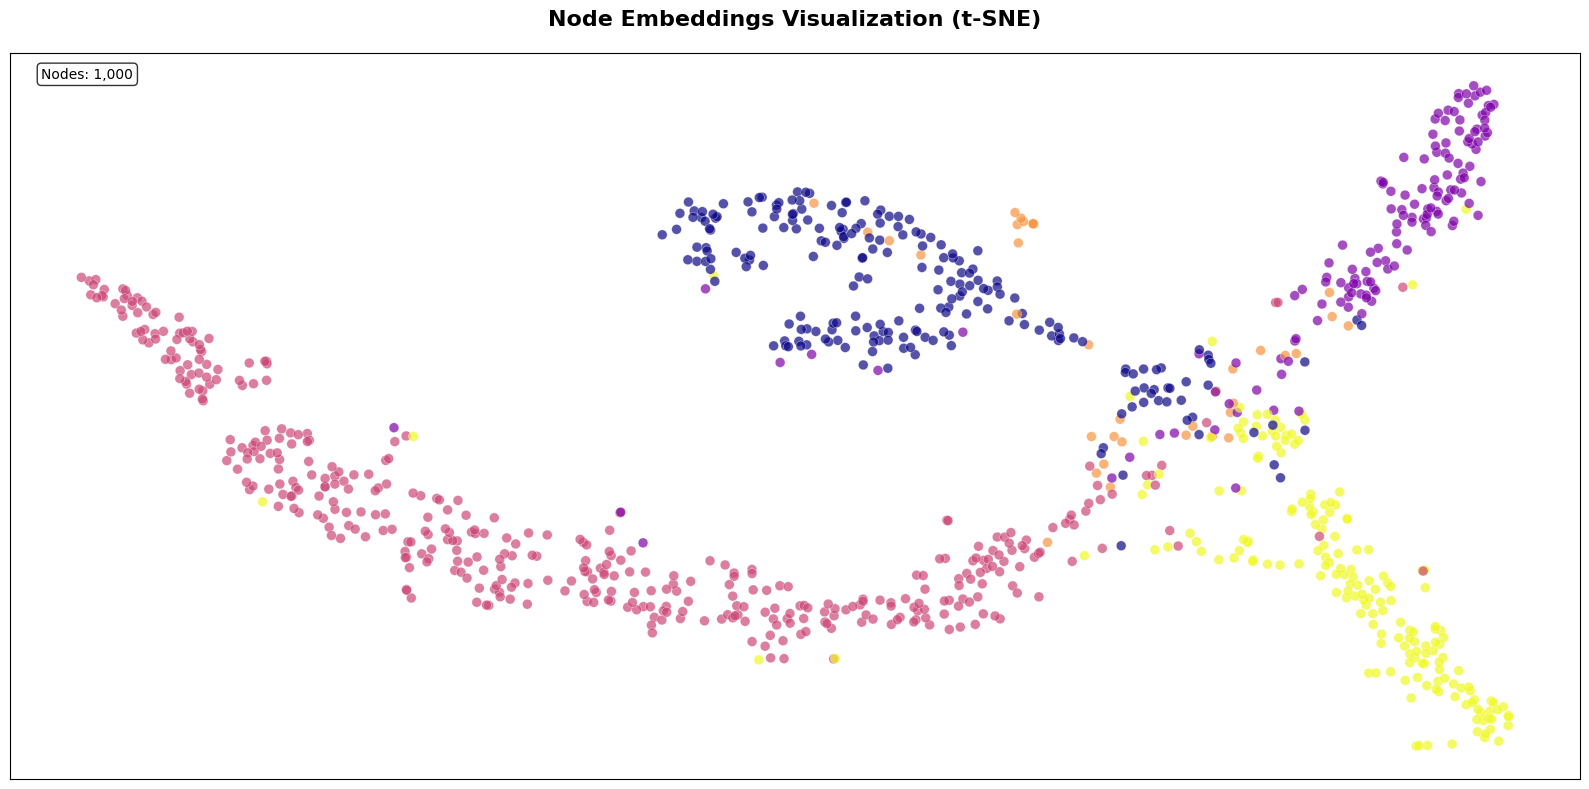

In [77]:
my_model.eval()
out = my_model(sub_g.x, sub_g.edge_index)
visualize_embeddings(out, color=sub_g.y, method='t-sne')

# По картинке классификация прошла не менее успешно. Точность чуть хуже, но также хорошая: 0.66